# Tutorial ALS con Implicit II

MAN 3160 - Sistemas Recomendadores

En este tutorial vamos explorar cómo podemos evaluar el método de ALS y cómo afectan los valores de los hiperparámetros en el rendimiento del agente.


## Importar Librerías

In [1]:
# Instalamos librerías para descarcar y descomprimir archivos.

!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse

## Entrenamiento de agente ALS

In [3]:
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

100% [......................................................] 4924029 / 4924029
Saved under ml-100k (1).zip


In [4]:
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [5]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv(f'{dir_train}/u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [7]:
# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [8]:
# Cargamos el dataset con los items
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv(f'{dir_train}/u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

### Ejemplo de diferencia train-test

In [10]:
df_train[df_train['userid'] == 157]

,userid,itemid,rating,timestamp
11620,157,1,1,874813703
11621,157,3,1,886890734
11622,157,25,1,886890787
11623,157,93,1,886890692
11624,157,111,1,886889876
11625,157,118,0,886890439
11626,157,120,0,886891243
11627,157,127,1,886890541
11628,157,137,1,886889876
11629,157,147,1,886890342


In [11]:
df_test[df_test['userid'] == 157]

,userid,itemid,rating,timestamp
3875,157,50,1,886890541
3876,157,100,1,886890650
3877,157,117,1,886890296
3878,157,255,1,886889876
3879,157,269,1,886889876
3880,157,286,1,874813268
3881,157,289,1,886889876
3882,157,290,1,886890787
3883,157,313,1,886889616
3884,157,340,1,886889616


In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

user_item_matrix = sparse.csr_matrix(sparse_matrix)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
items_ids = {key: i for i, key in enumerate(itemset)}

In [13]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares()
model_als.fit(user_item_matrix)

  0%|          | 0/15 [00:00<?, ?it/s]

### Métricas

In [14]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [15]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [16]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

## Evaluación del modelo

In [17]:
for n in [5, 10, 15, 20]:
    mmap, ndcg = evaluate_model(model_als, n)
    print(f'map@{n}: {mmap} \nndcg@{n}: {ndcg}')

map@5: 0.5502871362940265 
ndcg@5: 0.8024502297090352
map@10: 0.5106267794395843 
ndcg@10: 0.900459418070444
map@15: 0.47670375219108163 
ndcg@15: 0.9356814701378254
map@20: 0.45012677385745875 
ndcg@20: 0.9479326186830015


## Ajuste de hiperparámetros

In [18]:
factores = [i*5 for i in range(1, 15)]
reg_fac = [0.001, 0.01, 0.1]

map_f = []
ndcg_f = []

map_rg = []
ndcg_rg = []

for f in factores:
    model_als = implicit.als.AlternatingLeastSquares(factors=f)
    model_als.fit(user_item_matrix)
    mmap, ndcg = evaluate_model(model_als, 10)
    map_f.append(mmap)
    ndcg_f.append(ndcg)
    
for rg in reg_fac:
    model_als = implicit.als.AlternatingLeastSquares(regularization=rg)
    model_als.fit(user_item_matrix)
    mmap, ndcg = evaluate_model(model_als, 10)
    map_rg.append(mmap)
    ndcg_rg.append(ndcg)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

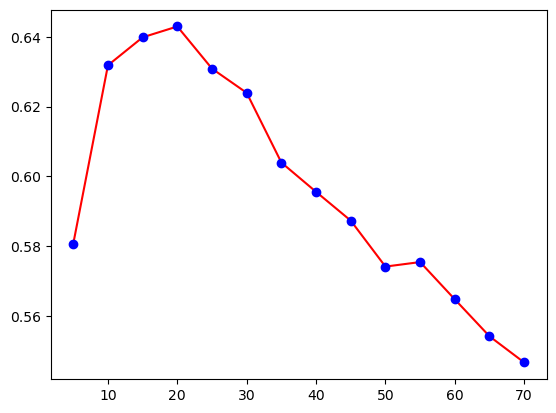

In [19]:
plt.plot(factores, map_f, 'r-')
plt.plot(factores, map_f, 'bo')
plt.show()

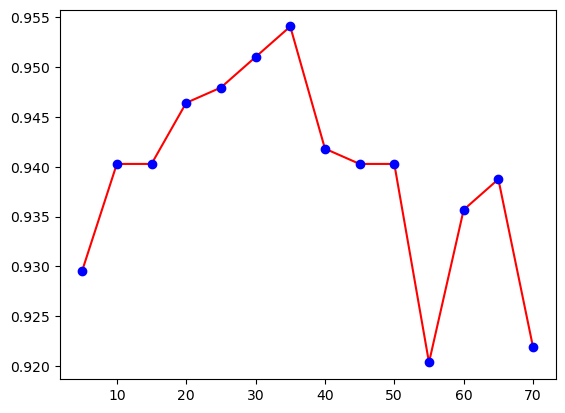

In [20]:
plt.plot(factores, ndcg_f, 'r-')
plt.plot(factores, ndcg_f, 'bo')
plt.show()

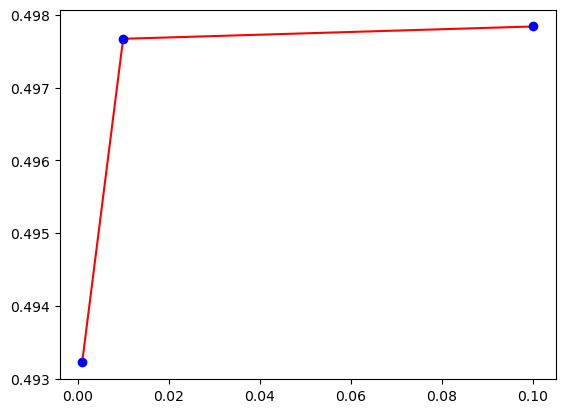

In [21]:
plt.plot(reg_fac, map_rg, 'r-')
plt.plot(reg_fac, map_rg, 'bo')
plt.show()